In [1]:
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


# <u>Data Preparation

In [69]:
# read images from folder
def load_images_folder():
    # training images
    images_train = []
    for name in range(28710):
        img = cv2.imread('output/Training/' + str(name) + '.jpg', 0)
        if img is not None:
            images_train.append(img)
    
    # validation images
    images_cv = []
    for name in range(28710, 32299):
        img = cv2.imread('output/PublicTest/' + str(name) + '.jpg', 0)
        if img is not None:
            images_cv.append(img)
    
    # test images
    images_test = []
    for name in range(32299, 35888):
        img = cv2.imread('output/PrivateTest/' + str(name) + '.jpg', 0)
        if img is not None:
            images_test.append(img)
            
    return images_train, images_cv, images_test 

In [70]:
# load the images
images_train, images_cv, images_test = load_images_folder()

In [2]:
# load the corresponding emotion values
emotions = pd.read_csv('emotions.csv', header=None)

In [72]:
images_train = np.array(images_train)
images_cv = np.array(images_cv)
images_test = np.array(images_test)

In [73]:
print(len(images_train))
print(len(images_cv))
print(len(images_test))
print(len(emotions))

28709
3589
3589
35887


In [93]:
# save the numpy matrix without preprocessing
np.save('train_raw.npy', images_train)
np.save('cv_raw.npy', images_cv)
np.save('test_raw.npy', images_test)

In [3]:
images_train = np.load('train_raw.npy')
images_cv = np.load('cv_raw.npy')
images_test = np.load('test_raw.npy')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001602615B470>]], dtype=object)

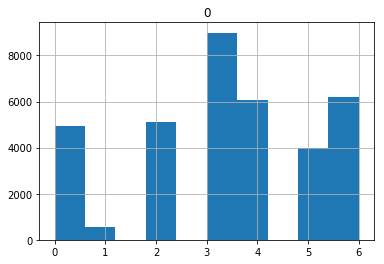

In [4]:
emotions.hist()

In [5]:
# distribution of pictures
emotions[0].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: 0, dtype: int64

In [6]:
# prepare output labels 
y_train = emotions[:images_train.shape[0]].values
y_cv = emotions[images_train.shape[0]:images_train.shape[0] + images_cv.shape[0]].values
y_test = emotions[images_train.shape[0] + images_cv.shape[0]: ].values

In [7]:
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(28709, 1)
(3589, 1)
(3589, 1)


In [8]:
def show(img):
    show_image = img.reshape(48,48)
    plt.imshow(show_image, cmap='gray')

Emotion:[0]


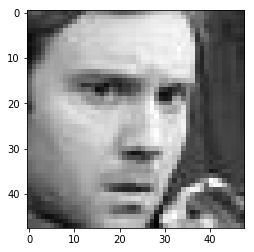

In [15]:
# verifying images
index = 0

#show training image
show(images_train[index])
print('Emotion:' + str(y_train[index]))

Emotion:[0]


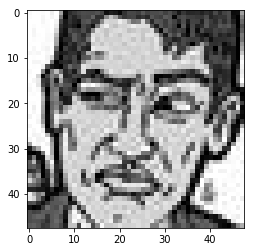

In [16]:
#show cv image
show(images_cv[index])
print('Emotion:' + str(y_cv[index]))

Emotion:[0]


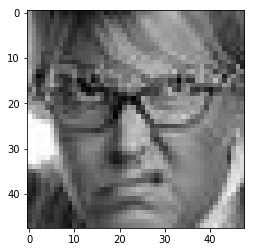

In [17]:
#show test image
show(images_test[index])
print('Emotion:' + str(y_test[index]))

In [11]:
# create one hot encoding
y_train_ohe = to_categorical(y_train, num_classes=7)
y_cv_ohe = to_categorical(y_cv, num_classes=7)
y_test_ohe = to_categorical(y_test, num_classes=7)

In [12]:
print(y_train_ohe.shape)
print(y_cv_ohe.shape)
print(y_test_ohe.shape)

(28709, 7)
(3589, 7)
(3588, 7)


# <u>Preprocessing

In [18]:
# preprocess the images
# training images
images_train = images_train/255
    
# cv images
images_cv = images_cv/255
    
# test images
images_test = images_test/255

In [16]:
# save the preprocessed images
np.save('train_img.npy', images_train)
np.save('cv_img.npy', images_cv)
np.save('test_img.npy', images_test)

In [20]:
# reshape the images for keras
images_train = np.expand_dims(images_train, 3)
images_cv = np.expand_dims(images_cv, 3)
images_test = np.expand_dims(images_test, 3)

In [21]:
print(images_train.shape)
print(images_cv.shape)
print(images_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


# <u>Model Architecture

In [22]:
from keras.callbacks import ModelCheckpoint

In [23]:
'''
saves the model weights after each epoch if the validation loss decreased
'''
checkpoint = ModelCheckpoint(filepath='weights_best.hdf5', verbose=1, save_best_only=True)

In [24]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 44, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 40, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 102400)            0         
__________

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [27]:
model.fit(images_train, y_train_ohe, batch_size=64, epochs=2, verbose=1,
          validation_data=(images_cv, y_cv_ohe), callbacks=[checkpoint])

model.save_weights('weights.h5')
model.save('model.h5')

Train on 28709 samples, validate on 3589 samples
Epoch 1/2
 1600/28709 [>.............................] - ETA: 59:38 - loss: 1.94 - ETA: 49:50 - loss: 1.94 - ETA: 47:15 - loss: 1.93 - ETA: 45:53 - loss: 1.94 - ETA: 44:43 - loss: 1.93 - ETA: 44:09 - loss: 1.92 - ETA: 43:53 - loss: 1.92 - ETA: 43:28 - loss: 1.92 - ETA: 42:49 - loss: 1.92 - ETA: 42:19 - loss: 1.92 - ETA: 42:12 - loss: 1.92 - ETA: 41:59 - loss: 1.92 - ETA: 41:30 - loss: 1.91 - ETA: 41:18 - loss: 1.91 - ETA: 41:09 - loss: 1.91 - ETA: 40:46 - loss: 1.91 - ETA: 40:32 - loss: 1.91 - ETA: 40:22 - loss: 1.91 - ETA: 40:21 - loss: 1.91 - ETA: 40:11 - loss: 1.91 - ETA: 40:15 - loss: 1.90 - ETA: 39:54 - loss: 1.90 - ETA: 39:43 - loss: 1.90 - ETA: 39:39 - loss: 1.90 - ETA: 39:39 - loss: 1.9032

KeyboardInterrupt: 